In [1]:
from matplotlib import pyplot as plt
from genPCCA import _initialize_rot_matrix, _gram_schmidt_mod, sort_real_schur, _opt_soft

import copy
import numpy as np
import scipy.linalg
import scipy.sparse

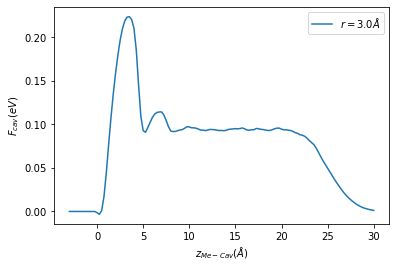

In [2]:
# Load data


data_path = ('./1D_Energy_Profile/Au3.0.dat')
E_Au_3_0 = np.loadtxt(data_path)
plt.plot(E_Au_3_0[:,0],E_Au_3_0[:,1], label=r'$r = 3.0 \AA$')
plt.legend()
plt.ylabel(r'$F_{cav}(eV)$')
plt.xlabel(r'$z_{Me-Cav}(\AA)$')
plt.savefig('Fcav_Au_3.pdf')

### Adjacency matrix

In [3]:
# check out networkx
def adjancency_matrix_sparse(nbins, nd, periodic=False):
    v = np.zeros(nbins)
    v[1] = 1
    
    if periodic:
        v[-1] = 1
        A0 = scipy.sparse.csc_matrix(scipy.linalg.circulant(v)) #.toarray()
    else:
        A0 = scipy.sparse.csc_matrix(scipy.linalg.toeplitz(v)) #.toarray()
    
    A = A0
    I2 = scipy.sparse.eye(nbins)  #np.eye(nbins)
    for _ in range(1, nd):
        I1 = scipy.sparse.eye(*A.shape) #np.eye(*A.shape)
        A =  scipy.sparse.kron(A0, I1) + scipy.sparse.kron(I2, A)
    return A

### Spatial discretization (ref: http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/)

In [4]:
def find_mid(sorted_list):
        acopy = sorted(sorted_list * 2)[1:-1]
        mid = [acopy[j]+((acopy[j+1]-acopy[j])/2) for j in range(0, len(acopy),2)]
        return mid

def generating_bins(E_pot,nedges, loop=2):
    # increase loop to have less random discretization
    random_float = sorted([np.random.uniform(min(E_pot), max(E_pot)) for i in range(nedges)])
    counter = loop
    bins = None
    
    while counter != 0:
        if counter == loop:
            midpoints = find_mid(random_float)
        else:
            edge = find_mid(bins)
            midpoints = find_mid(edge)
        bins = [min(E_pot)] + copy.deepcopy(midpoints) + [max(E_pot)]
        counter -= 1
        
    return bins

### 1D System - from MD

In [5]:
# System parameters
#kB    = 0.008314463 kJ/(mol.K)
kB    = 8.314463 

T     = 300 ## check from ouput
mass  = 238 ## a.m.u
gamma = 1
D     = kB * T / mass / gamma # diffusion coefficient
sigma = np.sqrt(2 * D) # diagonal matrix
beta  = 1 / kB / T

# Grid
nd     = 1  # Number of dimensions
nedges = 60 # State boundaries
x = E_Au_3_0[:,0]
dx = x[1] - x[0]
x = E_Au_3_0[26:102][::2]
v = E_Au_3_0[:,1][26:102][::2]*1.60218e-19

#### Build SqRA 1D

In [6]:
Nbins = len(x)

# Flux
A  = adjancency_matrix_sparse(Nbins, nd, periodic=False)
flux = D / dx**2 # Normalisation of Fick's second law?
Af   = flux * A 

# Diagonalization
SQRA = np.sqrt(np.exp(- beta * v)) # What happen to the partition function ?
SQRA = SQRA / sum(SQRA) # Normalized arithmetic mean of Boltzman density values of points in each Voronoi region
Di   = scipy.sparse.spdiags(SQRA, 0, Nbins, Nbins) # right eigenvector of Q''_c with eigenvalues close to 0
D1   = scipy.sparse.spdiags(1/SQRA, 0, Nbins, Nbins)       
Q    = D1 * Af * Di # basis transformation

Q    = Q + scipy.sparse.spdiags(-Q.sum(axis=1).T, 0, Nbins, Nbins) # compute diagonal elements of Q

### Apply PCCA+

Schur eigenvalues [ 1.00000000e+00  3.18074438e-01  1.03160468e-02  3.49240898e-05
  1.28303764e-08  5.39908657e-13  7.41307365e-17 -6.11011334e-17
 -5.93758483e-17  5.45136445e-17 -4.40862199e-17  4.81042012e-17
 -3.13165976e-17 -3.13165976e-17  3.28063011e-17 -2.57358623e-17
 -1.87579572e-17 -1.87579572e-17 -1.86351180e-17 -1.86351180e-17
 -1.05626360e-17 -1.05626360e-17  2.50593670e-17  2.50593670e-17
  2.16592969e-17  2.16592969e-17  6.91000098e-19  6.91000098e-19
  1.00927228e-17  1.00927228e-17  1.54467220e-17  2.92541369e-18
  2.92541369e-18  9.28758162e-18  4.44766548e-18 -6.76463464e-18
 -6.76463464e-18 -6.50956841e-18]


/Users/psireal42/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/psireal42/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


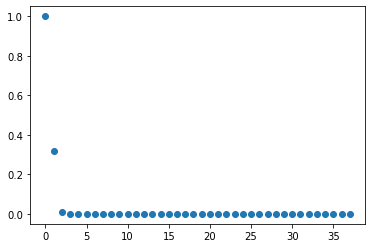

In [7]:
EPS = np.finfo(np.float64).eps

r = 2 # number of conformations
#eigenval, eigenvec = scipy.sparse.linalg.eigs(Q.T, r, which='LR')
Q1 = scipy.sparse.csr_matrix.copy(Q)
Q1 = scipy.linalg.expm(Q1)
#U, s, _ = scipy.sparse.linalg.svds(Q1)


Q2 = scipy.sparse.csr_matrix.toarray(Q1)
R, Q_new = scipy.linalg.schur(Q2, output='real')
print('Schur eigenvalues',R.diagonal())
plt.plot(R.diagonal(),'o')

### Schur Zerlegeung == Eigenwert Zerlegung
Q_new,R, ap = sort_real_schur(Q_new,R,'LM',r) # find the eigenwert !!!!
T, _ = scipy.linalg.rsf2csf(R, Q_new)
eigenvalues = np.diag(T)[:r]
Q, R, eigenvalues = Q_new[:, :r], R[:r, :r], eigenvalues[:r] # sorted_schur

eta = np.true_divide(np.ones(Q.shape[0]), Q.shape[0])
if not np.allclose(Q.T.dot(Q * eta[:, None]), np.eye(Q.shape[1]), rtol=1e6 * EPS, atol=1e6 * EPS): # do_schur
        Q = _gram_schmidt_mod(Q, eta)
        # Transform the orthonormalized Schur vectors of P_bar back
        # to orthonormalized Schur vectors X of P.
        X = np.true_divide(Q, np.sqrt(eta)[:, None])
else:
        # Search for the constant (Schur) vector, if explicitly present.
        n, m = Q.shape
        max_i = 0
        for i in range(m):
            vsum = np.sum(Q[:, i])
            dummy = np.ones(Q[:, i].shape) * (vsum / n)
            if np.allclose(Q[:, i], dummy, rtol=1e-6, atol=1e-5):
                max_i = i  # TODO: check, if more than one vec fulfills this

        # Shift non-constant first (Schur) vector to the right.
        Q[:, max_i] = Q[:, 0]
        # Transform the orthonormalized Schur vectors of P_bar back
        # to orthonormalized Schur vectors X of P.
        X = np.true_divide(Q, np.sqrt(eta)[:, None])
        # Set first (Schur) vector equal 1.
        X[:, 0] = 1.0


rot_matrix = _initialize_rot_matrix(X)
rot_matrix, chi, fopt = _opt_soft(X, rot_matrix) # membership functions
crispness = (r - fopt) / r

#plt.plot(chi)
plt.show()



Wenige Diskretisationsbox, sieht wie freie Diffusion aus, Temperatur zu hoch

### Compute Q<sub>c</sub>

In [8]:
w = np.exp(-v/(kB*T)) # energy is too small
sum_w = np.sum(w)
w = w/sum_w # make the temperature smaller 
D = np.diag(w)

#### R in Marcus's paper?
w_c
D_c
print(X.shape)

print(chi.shape)
print(Q.shape)
Q_c = scipy.linalg.inv(chi.T@D@chi)@(chi.T@D@Q@chi)
I = D@chi

/var/folders/20/g494tvg15z1ch3__m5vcn0b40000gn/T/ipykernel_4486/2267255030.py:1: RuntimeWarning: divide by zero encountered in true_divide
  w = np.exp(-v/(kB*T)) # energy is too small
/var/folders/20/g494tvg15z1ch3__m5vcn0b40000gn/T/ipykernel_4486/2267255030.py:1: RuntimeWarning: invalid value encountered in true_divide
  w = np.exp(-v/(kB*T)) # energy is too small


NameError: name 'w_c' is not defined